In [1]:
from tqdm import tqdm

In [2]:
import pandas as pd
from nltk.translate import bleu_score
from numpy.linalg import norm
import numpy as np

df = pd.read_csv("./data/comment_finder/all.csv")

chencherry = bleu_score.SmoothingFunction()

def getBleuScore(test_idx, match_idx):
    ref = df.iloc[[test_idx]].to_records()[0][2]
    hyp = df.iloc[[match_idx]].to_records()[0][2]
    bleu_score_val = bleu_score.sentence_bleu([ref], hyp, smoothing_function=chencherry.method1)
    return bleu_score_val

In [8]:
from libs.feature_extraction.vectorizers import BertVectorizer
import numpy as np
from scipy.signal import stft
import tensorflow as tf

bert = BertVectorizer("microsoft/unixcoder-base")
vectors = bert.load_vectors("data/comment_finder/vectors/bert_vectors.npy")
zero_vectors = np.zeros((vectors.shape[0], 4096))
zero_vectors[:vectors.shape[0], :vectors.shape[1]] = vectors
vectors = zero_vectors
vectors = vectors.reshape(vectors.shape[0], 1, 64, 64, 1)
display(vectors.shape)

Loading model(microsoft/unixcoder-base)...


(150677, 1, 64, 64, 1)

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
import tensorflow as tf

class VGG19DeepConvolutionNetwork:
    __model = None

    def __init__(self):
        self.model()

    def model(self, inputShape=(64, 64, 1)):

        inputLayer = Input(shape=inputShape)

        layerSet = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputLayer)
        layerSet = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(layerSet)
        layerSet = MaxPooling2D(strides=(2,2), padding='same')(layerSet)

        layerSet = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(layerSet)
        layerSet = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(layerSet)
        layerSet = MaxPooling2D(strides=(2,2), padding='same')(layerSet)

        layerSet = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(layerSet)
        layerSet = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(layerSet)
        layerSet = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(layerSet)
        layerSet = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(layerSet)
        layerSet = MaxPooling2D(strides=(2,2), padding='same')(layerSet)

        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(layerSet)
        layerSet = MaxPooling2D(strides=(2,2), padding='same')(layerSet)

        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(layerSet)
        layerSet = MaxPooling2D(strides=(2,2), padding='same')(layerSet)

        layerSet = Flatten()(layerSet)
        layerSet = Dense(4096, activation='relu')(layerSet)
        layerSet = Dropout(0.5)(layerSet)
        outputLayer = Dense(4096, activation='relu')(layerSet)
        #layerSet = Dropout(0.5)(layerSet)
        #outputLayer = Dense(1000, activation='relu')(layerSet)

        self.__model = Model(inputs=[inputLayer], outputs=[outputLayer])

        self.__model.compile(optimizer='adam', loss='cosine_similarity')
        print(self.__model.summary())

    def getModel(self):
        return self.__model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                           

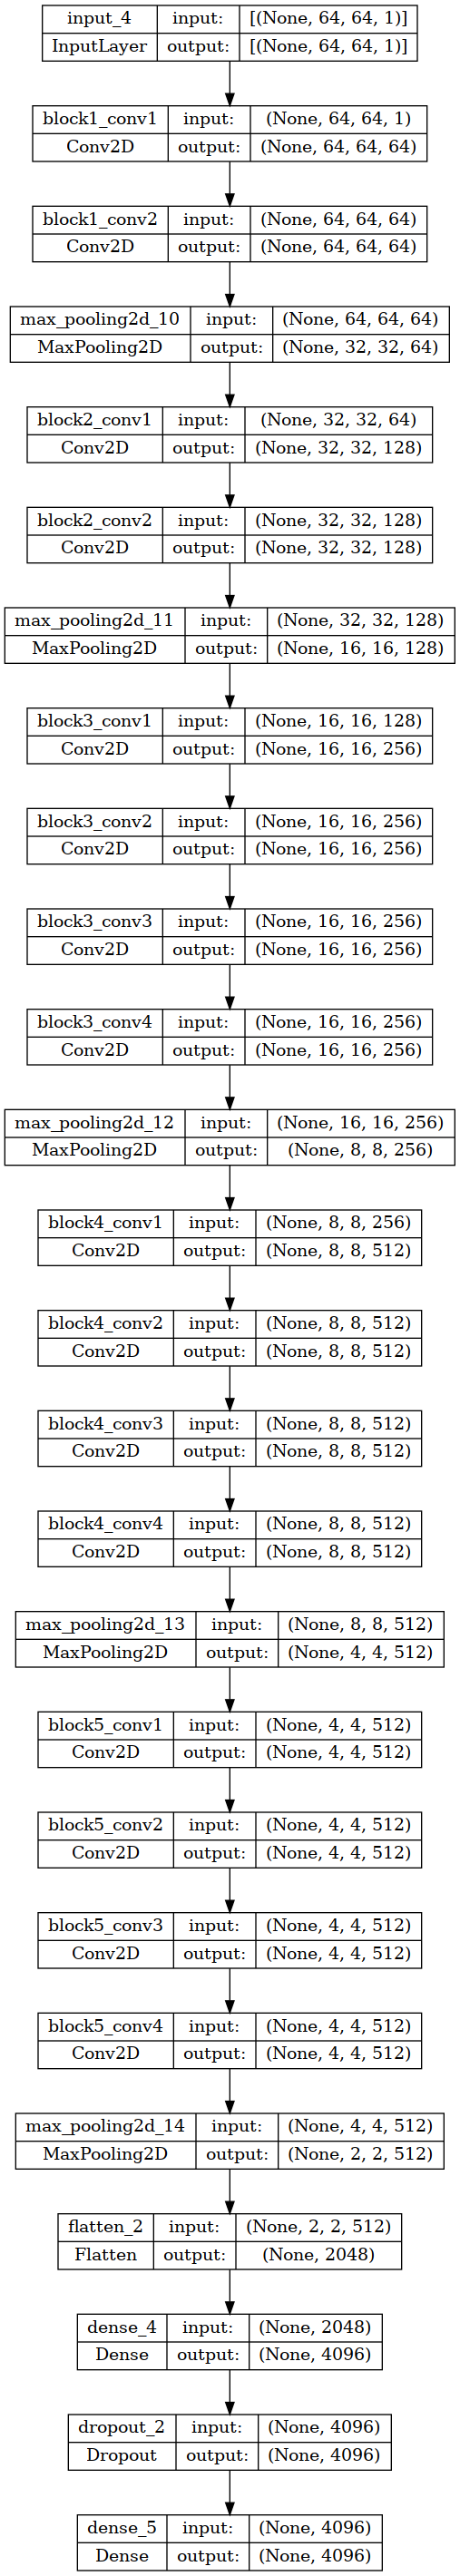

In [12]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image, display

modelWrapper = VGG19DeepConvolutionNetwork()
model = modelWrapper.getModel()
model.save('v6_vgg_64x64.h5')
plot_model(model, to_file='v6_vgg_64x64.png', show_shapes=True, show_layer_names=True)
display(Image("v6_vgg_64x64.png"))

In [14]:
preds_all = np.zeros((len(vectors),4096))
for j in tqdm(range(vectors.shape[0])):
    preds_all[j] = model.predict(vectors[j],verbose = 0)
np.save("v6_preds", preds_all)

100%|██████████| 150677/150677 [3:22:19<00:00, 12.41it/s]  


In [15]:
from annoy import AnnoyIndex

dims = 4096
trees = 10000
file_index_to_file_vector = {}

# build ann index
t = AnnoyIndex(dims, metric='angular')
for i in tqdm(range(preds_all.shape[0])):
    file_vector = preds_all[i]
    file_index_to_file_vector[i] = file_vector
    t.add_item(i, file_vector)
t.build(trees)
t.save("v6.annoy")

100%|██████████| 150677/150677 [00:45<00:00, 3300.05it/s]


True

In [16]:
from annoy import AnnoyIndex

dims = 4096
trees = 10000
file_index_to_file_vector = {}

# build ann index
t = AnnoyIndex(dims, metric='angular')
t.load("v6.annoy")
preds_all = np.load("v6_preds.npy")

In [17]:
test_df = pd.read_csv("./results/bert_cosine_bleu_C1_F5/fold_1.csv")
test_series = test_df.test_idx

sum = 0
toplam = 1000 #len(test_series)
for index, test_idx in tqdm(enumerate(test_series), total=toplam):
    if index > toplam-1:
        break
    nearest_neighbours = t.get_nns_by_vector(preds_all[test_idx], 10)
    max_sim_id = nearest_neighbours[1]
    bleu_score_val = getBleuScore(test_idx,max_sim_id)
    sum = sum + bleu_score_val
    
avg_bleu_score = sum / toplam
display(avg_bleu_score)

100%|██████████| 1000/1000 [13:20<00:00,  1.25it/s]


0.10136259415053687